In [1]:
# def calculate_pca(images):
#     X = images.copy()
#     # mean centering the data
#     X = X - X.mean(axis=0)

#     # covariance matrix
#     cov_mat = X.T @ X

#     # calculating eigenvalues and eigenvectors
#     eig_values, eig_vectors = np.linalg.eig(cov_mat)

#     # calculating portion of variance explained
#     pve = eig_values / np.sum(eig_values)

#     # sort eigenvectors and eigenvalues according to pve
#     idx = pve.argsort()[::-1]

#     eig_values = eig_values[idx]
#     eig_vectors = eig_vectors[:, idx]
#     pve = pve[idx]

#     return eig_values, eig_vectors, pve


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gzip

In [3]:
# Function to read pixel data from the dataset
def read_pixels(data_path):
    with gzip.open(data_path) as f:
        pixel_data = np.frombuffer(f.read(), 'B', offset=16).astype('float32')
    normalized_pixels = pixel_data / 255
    flattened_pixels = normalized_pixels.reshape(normalized_pixels.shape[0] // 784,784) # TODO: Flatten the normalized pixels
    return flattened_pixels

# Function to read label data from the dataset
def read_labels(data_path):
    with gzip.open(data_path) as f:
        label_data = np.frombuffer(f.read(), 'B', offset=8)
    return label_data

In [4]:
images = read_pixels("data/train-images-idx3-ubyte.gz")
labels = read_labels("data/train-labels-idx1-ubyte.gz")

In [5]:
# Helper Function to display an image
def display_image(image):
    plt.imshow(image.reshape(28, 28), cmap='gray')
    plt.axis('off')

def print_dashes():
    print('-' * 80)

In [6]:
class PCA():
    ''' 
    A class to perform PCA on a dataset.

    Attributes
    ----------
    fitted : bool
        A flag indicating whether the PCA object has been fitted.
    mean : numpy.ndarray
        The mean of the data.
    eigenvalues : numpy.ndarray
        The eigenvalues of the covariance matrix of the data.
    eigenvectors : numpy.ndarray
        The eigenvectors of the covariance matrix of the data.
    pve : numpy.ndarray
        The proportion of variance explained by each principal component.
    '''
    def __init__(self):
        self.fitted = False
        self.mean = None
        self.eigenvalues = None
        self.eigenvectors = None
        self.pve = None

    def fit(self, images):
        '''
        Fits the PCA object to the data.

        Parameters
        ----------
        images : numpy.ndarray
            The images to fit the PCA object to. 
        '''
        # I don't want to alter the original dataset, so I make a copy
        X = images.copy()

        # getting the mean of the data
        self.mean = X.mean(axis=0)

        # subtracting the mean from the data
        X = X - self.mean

        # calculating the covariance matrix
        cov_mat = X.T @ X

        # calculating the eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eig(cov_mat)

        # calculating the proportion of variance explained
        pve = eigenvalues / np.sum(eigenvalues)

        # sorting the eigenvalues and eigenvectors
        idx = pve.argsort()[::-1]

        # storing the sorted eigenvalues, eigenvectors, and pve
        self.eigenvalues = eigenvalues[idx]
        self.eigenvectors = eigenvectors[:, idx]
        self.pve = pve[idx]

        # deleting reference of X to free up memory by the garbage collector
        del X

        # setting the fitted flag to True
        self.fitted = True

    def transform(self, image, n_components):
        '''
        Transforms the image into the principal component space.

        Since I didn't alter the original dataset, I don't need to uncenter the data.

        Parameters
        ----------
        image : numpy.ndarray
            The image to transform.
        n_components : int
            The number of principal components to use.

        Returns
        -------
        numpy.ndarray
            The transformed image.
        '''
        # check if self.fitted
        if not self.fitted:
            raise Exception('PCA object has not been fitted.')
        
        
        projection = image @ self.eigenvectors[: ,:n_components]
        reconstructed_image = (projection @ self.eigenvectors[:, :n_components].T)
        reconstructed_image = reconstructed_image.reshape(28, 28)

        # if there is only one instance, return the first instance
        return reconstructed_image
        
        

In [7]:
# Creating a PCA object
pca = PCA()

# Fitting the PCA object to the images
pca.fit(images)

In [14]:
# define a function to visualize the PVE, take input as the number of components
def visualize_pca(pca, n_components):
    # make a histogram of the pve
    plt.bar(range(1,n_components+1), pca.pve[:n_components])
    # make x lines 1,2,3,4,5,6,7,8,9,10
    plt.xticks(range(1,n_components+1))
    plt.xlabel('Principal Component')
    plt.ylabel('Proportion of Variance Explained')
    plt.title('Proportion of Variance Explained by Each Principal Component')
    plt.show()

In [15]:
# QUESTION 1.1
# PVE for the first 10 principal components
print_dashes()
print("Question 1.1")
print("PVE for the first 10 principal components:\n")
for i in range(10):
    print(f"PC {i + 1}: {pca.pve[i]:.3f}")
print_dashes()

--------------------------------------------------------------------------------
Question 1.1
PVE for the first 10 principal components:

PC 1: 0.097
PC 2: 0.071
PC 3: 0.062
PC 4: 0.054
PC 5: 0.049
PC 6: 0.043
PC 7: 0.033
PC 8: 0.029
PC 9: 0.028
PC 10: 0.024
--------------------------------------------------------------------------------


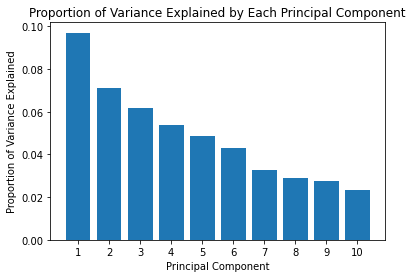

In [16]:
visualize_pca(pca, 10)

In [9]:
# QUESTION 1.2
print_dashes()
print("Question 1.2")
num_pcs = np.argmax(np.cumsum(pca.pve) >= 0.7) + 1
print(f"# of PCs required to explain the 70% of the data: {num_pcs}")
print_dashes()

--------------------------------------------------------------------------------
Question 1.2
# of PCs required to explain the 70% of the data: 26
--------------------------------------------------------------------------------


In [17]:
def plot_cumu_pve(pca):
    plt.plot(np.cumsum(pca.pve))
    plt.xlabel('Principal Component')
    plt.ylabel('Proportion of Variance Explained')
    plt.title('Cumulative Proportion of Variance Explained')
    plt.show()

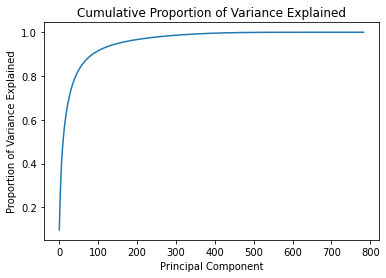

In [18]:
plot_cumu_pve(pca)

--------------------------------------------------------------------------------
Question 1.3
First 10 PCs:


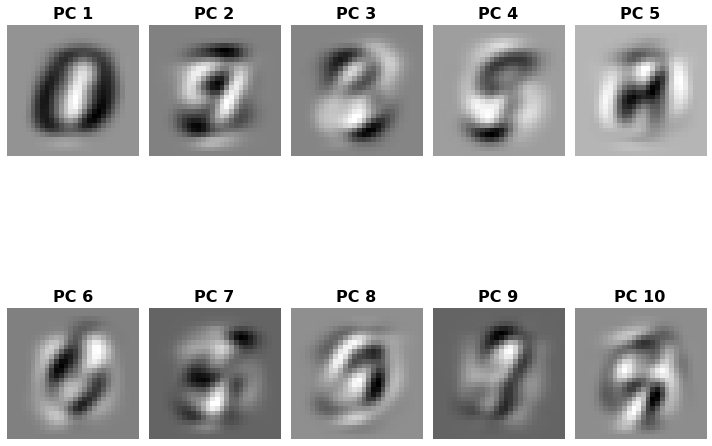

In [10]:
# QUESTION 1.3
print_dashes()
print("Question 1.3")
# getting the first 10 PCs
pc_10 = pca.eigenvectors[:, :10]

# Transposing the PCs
pc_10 = pc_10.T

# reshaping the PCs to 28x28
pc_10 = pc_10.reshape(10, 28, 28)

# applying min-max scaling to the each PCs individually
pc_10 = (pc_10 - pc_10.min(axis=(1, 2)).reshape(10, 1, 1))\
    / (pc_10.max(axis=(1, 2)).reshape(10, 1, 1) - pc_10.min(axis=(1, 2)).reshape(10, 1, 1))

# displaying the first 10 PCs
print("First 10 PCs:")
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(pc_10[i], cmap='gray')
    plt.axis('off')
    # make title bold

    plt.title(f"PC {i + 1}", fontsize=16, fontweight='bold')
plt.tight_layout(h_pad=0.1)

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Question 1.4


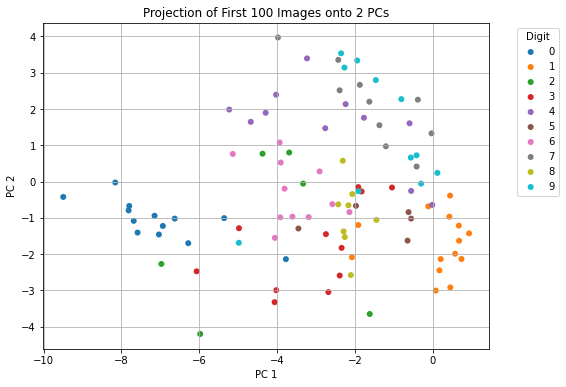

--------------------------------------------------------------------------------


In [11]:
print_dashes()
print_dashes()
print("Question 1.4")

# calculating the projection
projection = images[:100] @ pca.eigenvectors[:, :2]

cmap = plt.get_cmap('tab10')  # Using 'tab10' colormap for 10 colors

# Plotting the projected data points with different colors based on labels using colormap
plt.figure(figsize=(8, 6))

for i in range(10): 
    indices = labels[:100] == i
    plt.scatter(projection[indices, 0], projection[indices, 1],
                c=[cmap(i)], label=str(i), alpha=1, edgecolors='none')

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Projection of First 100 Images onto 2 PCs')
plt.legend(title='Digit', loc = "upper left", bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.show()

print_dashes()

--------------------------------------------------------------------------------
Question 1.5
Reconstructed Images:
--------------------------------------------------------------------------------


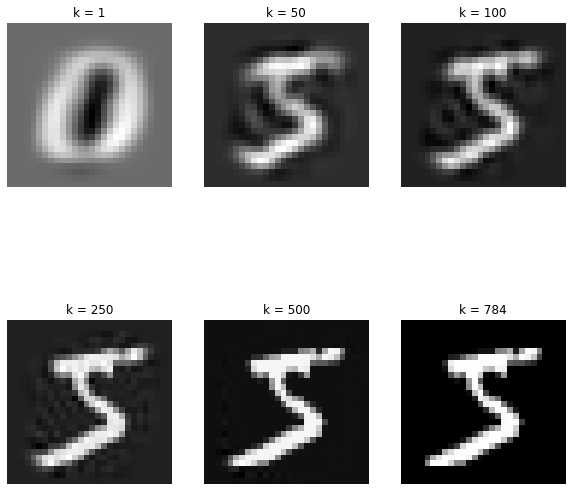

In [12]:
print_dashes()
print("Question 1.5")

# k values
k = np.array([1, 50, 100, 250, 500, 784])

# displaying the reconstructed images
print("Reconstructed Images:")
plt.figure(figsize=(10, 10))
image = images[0]

for i in range(6):
    plt.subplot(2, 3, i + 1)

    # reconstructing the image
    reconstructed_image = pca.transform(image, k[i])
    
    plt.title(f"k = {k[i]}")
    plt.imshow(reconstructed_image, cmap='gray')
    plt.axis('off')

print_dashes()